In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import strategy.trendlabeling as tlb
import numpy as np
import datetime

import getdata as gd
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import afml.util.multiprocess as mul
import features.bars as bars  
import features.marketindicators as mkt
import afml.features.fracdiff as fdiff

import plotly.graph_objects as go
import plotly.io as pio
import plotnine as pn

pio.renderers.default = "browser"

c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


1. Import Dataset

In [2]:
df_yf = gd.get_yf_data(tickers= "SPY AAPL ALGM DNOW META", 
                    period='60d', #'1y',   
                    interval='5m' #'1d'
)

[*********************100%***********************]  5 of 5 completed


In [3]:
df = df_yf[df_yf['Ticker'] == 'ALGM']

In [4]:
fig = go.Figure(data=go.Candlestick(x=df.index,
                    open=df.Open,
                    high=df.High,
                    low=df.Low,
                    close=df['Adj Close']))
fig.show()

2. Form Dollar Bars

In [5]:
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

In [6]:
# define the dollar value to sample the data
frequency = df['Volume']*df['Adj Close'].resample('D').sum().mean()/10.0

# generate the dollar bars
ans = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = ans.close.copy()

In [7]:
fig = go.Figure(data=go.Candlestick(x=ans.index,
                    open=ans['open'],
                    high=ans['high'],
                    low=ans['low'],
                    close=ans['close']))
fig.show()

3. Run cusum filter to get std dev of daily returns at equal threshold

In [8]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

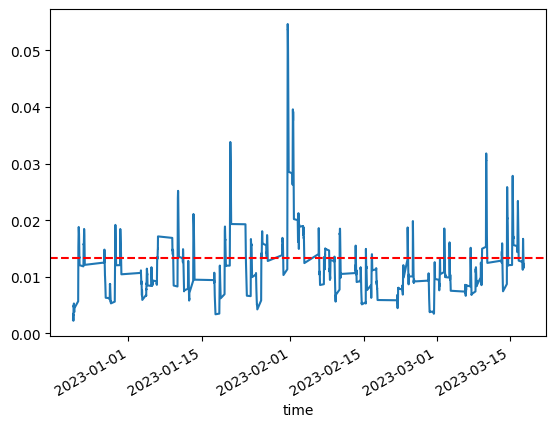

In [9]:
# show volitility over time

f,ax=plt.subplots()
dailyVolatility.plot(ax=ax)
ax.axhline(dailyVolatility.mean(),ls='--',color='r')

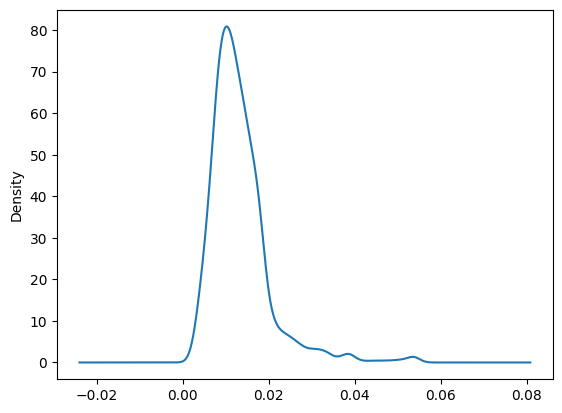

In [10]:
#show distribution of volitility
ax = dailyVolatility.plot.kde()

In [11]:
# apply cusum filter
tEvents = flt.getTEvents(close,h=dailyVolatility.mean())
tEvents

DatetimeIndex(['2022-03-22', '2022-03-23', '2022-03-25', '2022-03-29',
               '2022-03-31', '2022-04-04', '2022-04-05', '2022-04-07',
               '2022-04-11', '2022-04-13',
               ...
               '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14',
               '2023-03-15', '2023-03-16'],
              dtype='datetime64[ns]', length=157, freq=None)

4. Add vertical barrier a.k.a. event end date

In [12]:
# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)
t1

2022-03-22   2022-04-04
2022-03-23   2022-04-04
2022-03-25   2022-04-04
2022-03-29   2022-04-11
2022-03-31   2022-04-11
                ...    
2023-02-28   2023-03-10
2023-03-01   2023-03-13
2023-03-02   2023-03-13
2023-03-03   2023-03-13
2023-03-06   2023-03-16
Name: time, Length: 149, dtype: datetime64[ns]

5. Apply Triple Barrier method where ptSl = [2,1]  (2 to 1 profit ratio). Getting the Time of the First Touch, with Meta Labels

In [13]:
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(close, 
                         t_events=tEvents[1:], 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=None).dropna()

print(events)

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\labeling\triplebarrier.py:50: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                   t1      trgt  pt  sl
2022-03-23 2022-03-29  0.018217   2   1
2022-03-25 2022-04-04  0.036385   2   1
2022-03-29 2022-04-05  0.035012   2   1
2022-03-31 2022-04-07  0.039976   2   1
2022-04-04 2022-04-07  0.035391   2   1
...               ...       ...  ..  ..
2023-02-28 2023-03-10  0.040923   2   1
2023-03-01 2023-03-13  0.040124   2   1
2023-03-02 2023-03-13  0.039333   2   1
2023-03-03 2023-03-13  0.038813   2   1
2023-03-06 2023-03-16  0.038178   2   1

[148 rows x 4 columns]


6. Labeling for Side & Size with Meta Labels by generating outcome label using getBins

In [14]:
labels = tbar.get_bins(triple_barrier_events = events, close=close)

In [15]:
print(labels)
print(labels.bin.value_counts())

                 ret      trgt  bin
2022-03-23  0.061462  0.018217    1
2022-03-25 -0.035641  0.036385    0
2022-03-29 -0.116805  0.035012   -1
2022-03-31 -0.105282  0.039976   -1
2022-04-04 -0.097015  0.035391   -1
...              ...       ...  ...
2023-02-28  0.008700  0.040923    0
2023-03-01 -0.010966  0.040124    0
2023-03-02 -0.020145  0.039333    0
2023-03-03 -0.046476  0.038813   -1
2023-03-06  0.014994  0.038178    0

[148 rows x 3 columns]
 0    81
 1    35
-1    32
Name: bin, dtype: int64


7. Drop underpopulated labels (snippet 3.8) by eliminating rare observations

In [16]:
clean_labels  = tbar.drop_labels(labels)
print(clean_labels)

                 ret      trgt  bin
2022-03-23  0.061462  0.018217    1
2022-03-25 -0.035641  0.036385    0
2022-03-29 -0.116805  0.035012   -1
2022-03-31 -0.105282  0.039976   -1
2022-04-04 -0.097015  0.035391   -1
...              ...       ...  ...
2023-02-28  0.008700  0.040923    0
2023-03-01 -0.010966  0.040124    0
2023-03-02 -0.020145  0.039333    0
2023-03-03 -0.046476  0.038813   -1
2023-03-06  0.014994  0.038178    0

[148 rows x 3 columns]


In [17]:
clean_labels.bin.value_counts()

 0    81
 1    35
-1    32
Name: bin, dtype: int64

## Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time.

In [18]:
import afml.sampling.concurrent as cur
import afml.sample_weights.attribution as atr

In [19]:
close

time
2022-03-18    29.500000
2022-03-22    29.070000
2022-03-23    28.309999
2022-03-25    29.180000
2022-03-29    30.049999
                ...    
2023-03-10    44.060001
2023-03-13    43.290001
2023-03-14    45.160000
2023-03-15    44.470001
2023-03-16    46.029999
Name: close, Length: 169, dtype: float64

In [20]:
# compute the number of concurrent events per bar.
numCoEvents = mul.mp_pandas_obj(cur.num_concurrent_events,('molecule', events.index),                         
                              cpus, close_series_index=close.index, label_endtime=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()

# Estimating the Average Uniqueness of a Label
out['tW'] = mul.mp_pandas_obj(cur._get_average_uniqueness,('molecule', events.index),
                            cpus,label_endtime=events['t1'],num_conc_events=numCoEvents)

# Determination of Sample Weight by Absolute Return Attribution

out['w']=mul.mp_pandas_obj(atr._apply_weight_by_return,('molecule', events.index),cpus,
                         label_endtime=events['t1'],num_conc_events=numCoEvents,close_series=close)
out['w']*=out.shape[0]/out['w'].sum()

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\sampling\concurrent.py:31: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:113: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\sampling\concurrent.py:48: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

c:\Users\choit\OneDrive\Coursera\S

Text(0.5, 0.98, '# of Cocurrent Events by Timestamp')

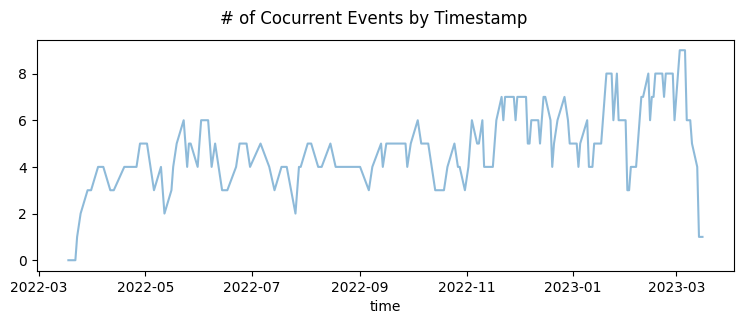

In [21]:
fig, ax = plt.subplots(figsize=(9,3))
numCoEvents.plot(subplots=True, alpha=0.5, ax=ax, x='index')
fig.suptitle('# of Cocurrent Events by Timestamp')

C:\Users\choit\AppData\Local\Temp\ipykernel_5900\31680795.py:2: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



Text(0.5, 0.98, 'Avg Uniqueness of Label (Top) & Sample Weight by Absolute Return Attribution (Bottom)')

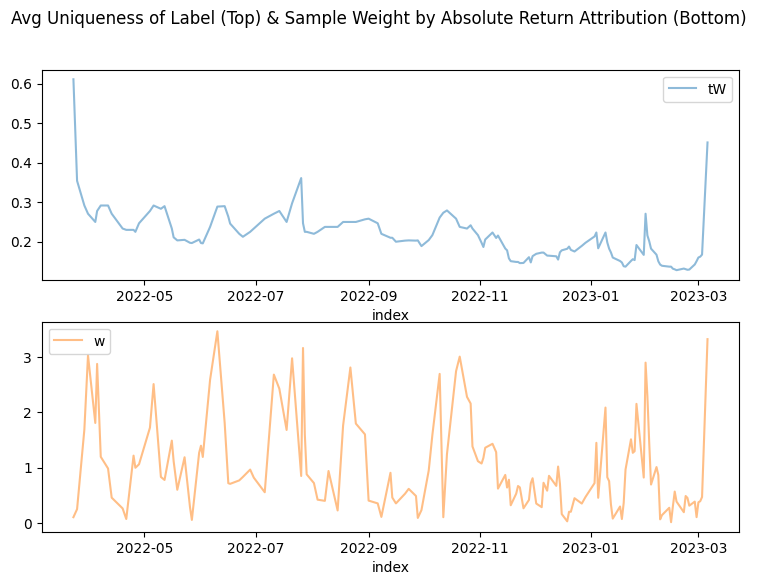

In [22]:
fig, ax = plt.subplots(figsize=(9,6))
out.reset_index().plot(subplots=True, alpha=0.5, ax=ax, x='index')
fig.suptitle('Avg Uniqueness of Label (Top) & Sample Weight by Absolute Return Attribution (Bottom)')

#### Plot the time series of number of concurrent labels on primary axis and time series of exponentially weighted moving standard deviation of returns on secondary axis

In [23]:
coEvents_std = (
    pd.DataFrame()
    .assign(
        numCoEvents = numCoEvents,
        std = mkt.returns(close).ewm(50).std())
)

Text(0.5, 0.98, 'Label Concurrency vs Returns Volitility')

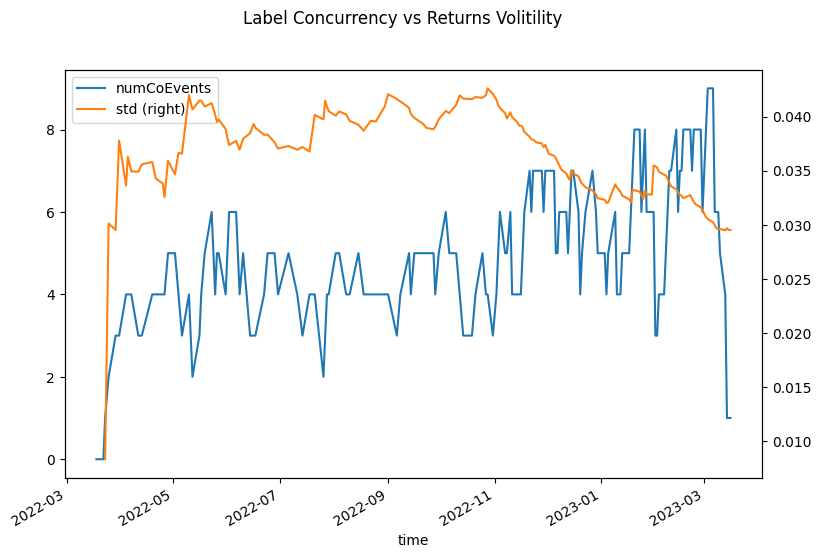

In [24]:
fig, ax = plt.subplots(figsize=(9,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax, x='index')
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax, x='index')
fig.suptitle('Label Concurrency vs Returns Volitility')

#### Scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving std dev of returns (y-axis)

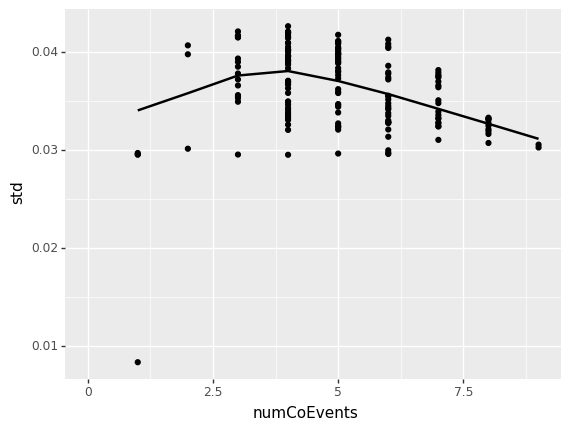

<ggplot: (152464055083)>

In [25]:
import warnings
warnings.filterwarnings("ignore")

(pn.ggplot(coEvents_std, pn.aes('numCoEvents', 'std'))
 +pn.geom_point()
 +pn.stat_smooth())

## Fractionally Differentiated Features

In [ ]:
# fractional differentiated log prices

# cumulative sum of stock log-prices
ticker_log_cumsum = np.log(dollar_bars.close).cumsum()
ticker_log_cumsum.plot()

In [ ]:
dfx1 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=1).dropna()
dfx2 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=2).dropna()

In [ ]:
import scipy.stats as stats

# Jarque-Bera normality test on the fracdiff series

np.random.seed(0)
stats.jarque_bera(dfx1)
stats.jarque_bera(dfx2)